Generated on Google Colab. Hence, best suited to work in that environment. 

In [ ]:
# Downloads the dataset

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:       # filter out keep-alive new chunks
                f.write(chunk)


file_id = '1Z73UHw9IS492qxHvNUiB7-DidVl_ePfg'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)



In [ ]:
!unzip -q dataset.zip
!rm -rf dataset.zip



replace dataset/Image1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Creating the noises to add into the images

from skimage.util import random_noise
import numpy as np
import random
import math

class NoisySystem():
  def example(self,img,**kwargs):
    noisy_image = random_noise(img,**kwargs)
    noisy_image = np.uint8(noisy_image*255)
    return noisy_image

  def create_salt_and_pepper_noise(self,img,amount=0.05):

    noisy_image = img.copy()    				# creating a copy of img in which to introduce noise
    n,m = noisy_image.shape

    num_pixels_salt = int(m*n*(amount/2))     	# Number of pixels into which introduce "salt" noise 
    for _ in range(num_pixels_salt):
        y = random.randint(0,n-1)
        x = random.randint(0,m-1)
        noisy_image[y][x] = 0
    
    num_pixels_pepper = int(m*n*(amount/2))   	# Number of pixels into which introduce "salt" noise 
    for _ in range(num_pixels_pepper//2):
        y = random.randint(0,n-1)
        x = random.randint(0,m-1)
        noisy_image[y][x] = 255

    return noisy_image



  def create_gaussian_noise(self,img,mean=0,var=10):

    std_dev = math.sqrt(var)
    noisy_image = img.copy()    									                  # creating a copy of img in which to introduce noise
    gaussian_noises = (np.random.normal (mean, var, img.shape))   	# creating a gaussian noise image of original img size
    noisy_image = noisy_image + gaussian_noises   					        # introducing gaussian noise
    noisy_image = np.ceil(noisy_image)            					        # Validating the result into integers [0,255] range

    return noisy_image 





Total Time taken: 0.02s

Statistics:
SNP -> PSNR: 17.82 | MSE: 1073.45
GSN -> PSNR: 20.49 | MSE: 581.22


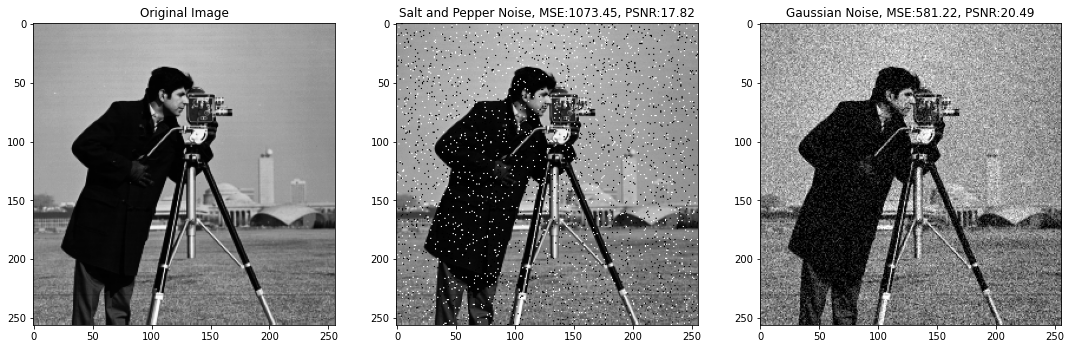

In [ ]:
def show_gray(img,title=""):
  plt.imshow(img,cmap='gray')
  plt.title(title)


#@title Observations { vertical-output: true, display-mode: "form" }
image_number = 3 #@param {type:"slider", min:1, max:10, step:1}
# %%timeit 

%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.metrics import mean_squared_error as MSE, peak_signal_noise_ratio as PSNR

clear_output(wait=True)

start = time.time()

noise_maker               = NoisySystem()
image                     = cv2.imread(f"/content/dataset/Image{image_number}.png")
image                     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

salt_and_pepper_example   = noise_maker.example(image.copy(),mode="s&p")
gaussian_example          = noise_maker.example(image.copy(),mode="gaussian")
salt_and_pepper_image     = noise_maker.create_salt_and_pepper_noise(image.copy())
gaussian_image            = noise_maker.create_gaussian_noise(image.copy())

end = time.time()
print(f"Total Time taken: {end-start:.2f}s\n")
print("Statistics:")
print(f"SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")


fig = plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
show_gray(image,"Original Image")
plt.subplot(2,3,2)
show_gray(salt_and_pepper_example, f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(2,3,3)
show_gray(gaussian_example, f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
fig.tight_layout()
plt.show()




Note :- For denoising, I am taking the reflection for padding. That will cover the "list index out of range" error along with calculating the correct value of the neighbour pixels. Because, reflecting a neighbourhood does not change the intensity values of individual pixels. 

Using Non Local Means algorithm, self written code. 

In [ ]:
from google.colab.patches import cv2_imshow

class NLMeans():
  def example(self,img,**kwargs):
    denoised_image = cv2.fastNlMeansDenoising(img,**kwargs)
    return denoised_image

  def solve(self,image,h=15,small_window=7,big_window=21):
    """
    To perform MLMeans filtering.

    :param img: noisy image
    :param h: sigma h (as mentioned in the paper)
    :param small_window: size of small window
    :param big_window: size of big window
    :rtype: uint8 (w,h)
    :return: solved image
    """
            
    
    ###############################################################
    
    # print("\n\n"); cv2_imshow(image)    # Debug Purpose
    img = np.copy(image)
    n,m = img.shape    
    big_window_half = big_window//2
    small_window_half = small_window//2

    # refleting the edges to pad the image to avoid "list index out of range" error
    padding_img = np.pad(img, big_window_half, mode='reflect')
    # A 4-dimensional array to store small neighbours (nbd in short) for each pixel for memoization
    neighbours  = np.zeros((n+2*big_window_half, m+2*big_window_half, small_window, small_window))
    # print("\n\n"); cv2_imshow(padding_img)    # Debug Purpose
    
    
    for i in range(big_window_half, n+big_window_half):
        for j in range(big_window_half, m+big_window_half):

            # Filling the nbd array wrt small patches
            w = max(i-small_window_half, 0)
            x = max(j-small_window_half, 0)
            y = min(i+small_window_half+1, n-1+2*big_window_half)
            z = min(j+small_window_half+1, m-1+2*big_window_half)
            neighbours[i,j] = padding_img[w:y,x:z]

    
    ###############################################################


    denoised_img = np.zeros(img.shape)
    # print("\n\n"); cv2_imshow(denoised_img)    # Debug Purpose
    # pi = pj = 0    # Debug Purpose


    # Actual denoising
    # traversing each pixel and calculating the average value using similar pixels

    for i in range(big_window_half, n+big_window_half):
        for j in range(big_window_half, m+big_window_half):

            # current big patch and its corresponding small patches
            currentWindow = neighbours[i,j]

            # Filling the nbd array wrt big patches
            w = max(i-big_window_half, 0)
            x = max(j-big_window_half, 0)
            y = min(i+big_window_half+1, n-1+2*big_window_half)
            z = min(j+big_window_half+1, m-1+2*big_window_half)
            big_windows_neighbours = neighbours[w:y, x:z]
            
            # Fiding the weighted sum between similar patches
            weights_total_sum = weight_total = 0

            for ii in range(2*big_window_half):
                for jj in range(2*big_window_half):
                    if ((ii,jj) != (i,j)):    # We must not calculate for a pixel wrt itself

                        # the neighbours of pixel ii,jj in nbd 4D array
                        currentNeighbour = big_windows_neighbours[ii,jj]
                        # weight calculated by exponential formula to be used to calculate average pixel value
                        currentWeight = np.exp(-1*((np.sum((currentWindow - currentNeighbour)**2)) / (h*small_window)**2))
                        # updating the total weight using above weight
                        weight_total += currentWeight
                        # updating total sum wrt current small patch 
                        weights_total_sum += (currentWeight*(currentNeighbour[small_window//2, small_window//2]))
        
            # Clipping the intensity values of pixels of denoised_img
            k = weights_total_sum/weight_total
            if (k>255): denoised_img [i-big_window_half, j-big_window_half] = 255
            elif (k<0): denoised_img [i-big_window_half, j-big_window_half] =  0
            else :      denoised_img [i-big_window_half, j-big_window_half] =  k
        
            # if(pi<10 and pj<10): print("\n\n"); cv2_imshow(denoised_img)    # Debug Purpose

        # if(pi<10): print("\n\n"); cv2_imshow(denoised_img)    # Debug Purpose
    
    # print("\n\n"); cv2_imshow(denoised_img)    # Debug Purpose

    return denoised_img





(Inbuilt) Time taken: 0.16s

(My function) Time taken: 544.57s

Statistics:
salt_and_paper_h: 30 , gaussian_h: 30

Noisy   => SNP -> PSNR: 18.09 | MSE: 1008.44
Noisy   => GSN -> PSNR: 20.50 | MSE: 580.17
Skimage => SNP -> PSNR: 24.57 | MSE: 226.99
Skimage => GSN -> PSNR: 26.84 | MSE: 134.63


<ipython-input-15-4cc4674d4e24>:59: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  show_gray(my_salt_and_pepper_denoise, f"My Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
<ipython-input-15-4cc4674d4e24>:61: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  show_gray(my_gaussian_denoise, f"My Gaussian Denoise, MSE:{MSE(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")


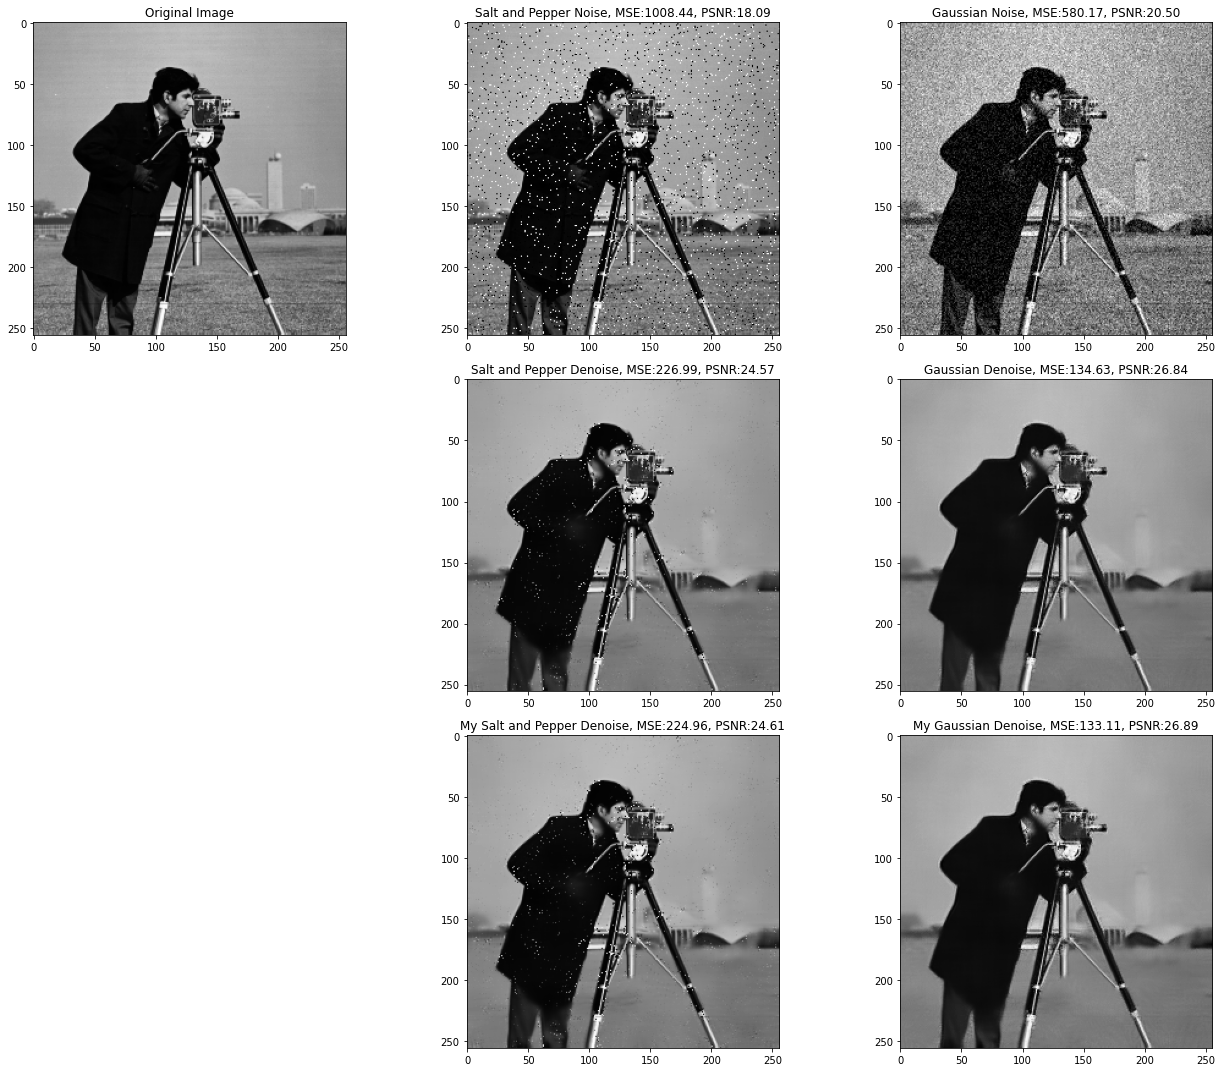

In [ ]:
#@title Observations { vertical-output: true, display-mode: "form" }
image_number = 3        #@param {type:"slider", min:1, max:10, step:1}
salt_and_paper_h = 30   #@param {type:"integer"}
gaussian_h = 30         #@param {type:"integer"}

# %%timeit 
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.metrics import mean_squared_error as MSE, peak_signal_noise_ratio as PSNR
 
clear_output(wait=True)
 
 
denoiser                    = NLMeans()
image                       = cv2.imread(f"/content/dataset/Image{image_number}.png")
image                       = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
salt_and_pepper_example     = noise_maker.example(image.copy(),mode="s&p")
gaussian_example            = noise_maker.example(image.copy(),mode="gaussian")
 
start = time.time()
 
salt_and_pepper_denoise     = denoiser.example(salt_and_pepper_example.copy(),h=salt_and_paper_h)
gaussian_denoise            = denoiser.example(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(Inbuilt) Time taken: {end-start:.2f}s\n")
 
start = time.time()
 
my_salt_and_pepper_denoise  = denoiser.solve(salt_and_pepper_example.copy(),h=salt_and_paper_h)
my_gaussian_denoise         = denoiser.solve(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(My function) Time taken: {end-start:.2f}s\n")
 
print("Statistics:")
print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"Skimage => SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"Skimage => GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | MSE: {MSE(gaussian_denoise,image):.2f}")
 
fig = plt.figure(figsize=(18,15))
plt.subplot(3,3,1)
show_gray(image,"Original Image")
plt.subplot(3,3,2)
show_gray(salt_and_pepper_example, f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(3,3,3)
show_gray(gaussian_example, f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(3,3,5)
show_gray(salt_and_pepper_denoise, f"Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,6)
show_gray(gaussian_denoise, f"Gaussian Denoise, MSE:{MSE(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
plt.subplot(3,3,8)
show_gray(my_salt_and_pepper_denoise, f"My Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,9)
show_gray(my_gaussian_denoise, f"My Gaussian Denoise, MSE:{MSE(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")
fig.tight_layout()
plt.show()

# Comparison between NL Means denoising and Gaussian Denoising.

If we compare MSE and PSNR values for the MyNLM and Gaussian Denoising methods respectively, we can observe :

The gaussian filtering is better for Salt&Pepper noises. This happens because this type of noise is concentrated on a particular pixel only, leaving many other pixels unaffected. 

From the observations, it seems that both NLMeans and Gaussian Filtering can work to denoise gaussian noised images. This happed because, I kept variance for gaussian noise low=10. If there is gaussian noise with big variance (say 100), the NLM will be better for denoising the gaussian noise.
Hence, in general, NLMeans is better to denoise Gaussian Noises. 

In [ ]:
import cv2

class GaussianFilter():

  def solve(self, img, ksize=(5,5), sigma_x=0):
    """
    Solve function to perform gaussian filtering.

    :param img: noisy image
    :param ksize: representing the size of the kernel.
    :param sigma_x: standard deviation in X direction
    :rtype: uint8 (w,h)
    :return: solved image
    """

    image = cv2.GaussianBlur(img, ksize, sigma_x, cv2.BORDER_DEFAULT)
    
    return image

Total Time taken: 0.00s

Statistics:
InBuilt GSN FLT -> PSNR: 24.14 | MSE: 250.75


<ipython-input-32-2c67c2fdf1f5>:34: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  show_gray(gaussian_image_filtered, f"Gaussian GSN, MSE:{MSE(image,gaussian_image_filtered):.2f}, PSNR:{PSNR(image,gaussian_image_filtered):.2f}")


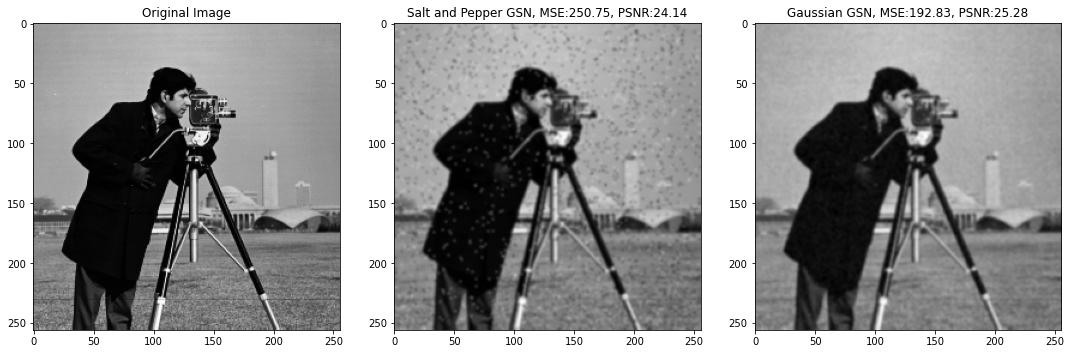

In [ ]:
#@title Observations { vertical-output: true, display-mode: "form" }
image_number = 3 #@param {type:"slider", min:1, max:10, step:1}
# %%timeit 

%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output(wait=True)

start = time.time()

image                     = cv2.imread(f"/content/dataset/Image{image_number}.png")
image                     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

salt_and_pepper_image_filtered = GaussianFilter.solve(None,(salt_and_pepper_image.copy()))
gaussian_image_filtered        = GaussianFilter.solve(None,(gaussian_image.copy()))


end = time.time()
print(f"Total Time taken: {end-start:.2f}s\n")
print("Statistics:")
print(f"InBuilt GSN FLT -> PSNR: {PSNR(salt_and_pepper_image_filtered,image):.2f} | MSE: {MSE(salt_and_pepper_image_filtered,image):.2f}")


fig = plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
show_gray(image,"Original Image")
plt.subplot(2,3,2)
show_gray(salt_and_pepper_image_filtered, f"Salt and Pepper GSN, MSE:{MSE(image,salt_and_pepper_image_filtered):.2f}, PSNR:{PSNR(image,salt_and_pepper_image_filtered):.2f}")
plt.subplot(2,3,3)
show_gray(gaussian_image_filtered, f"Gaussian GSN, MSE:{MSE(image,gaussian_image_filtered):.2f}, PSNR:{PSNR(image,gaussian_image_filtered):.2f}")
fig.tight_layout()
plt.show()